In [2]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import matplotlib.colors as mcolors
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import max_cut, tsp, common
from qiskit.aqua.algorithms import VQE, ExactEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA, ADAM
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.qasm import pi

from docplex.mp.model import Model
from qiskit.optimization.ising import docplex

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
from qiskit import IBMQ
provider = IBMQ.load_account()

In [225]:
class circuits:
    def __init__(self, n, k):
        self.n = n
        self.k = k
        self.circ = QuantumCircuit(self.n*k+1, self.n*k+1)
        for j in range(self.n):
            theta = np.zeros(k)
            for i in range(k):
                theta[i] = 2*np.arcsin(1/np.sqrt(k-i))
                self.circ.cx(j*k+i, j*k+i+1)
                self.circ.x(j*k+i+1)
                self.circ.cry(theta[i], j*k+i+1,j*k+i)
                self.circ.x(j*k+i+1)
                self.circ.cx(j*k+i, j*k+i+1)
                self.circ.swap(j*k+i+1, j*k+i)
            self.circ.x(j*k+k)
    
    def beta_gate(self, k, beta, qbit):
        #XY simulatenous mixer
        q = qbit
        par = 1
        if k>2:
            par = 0
        for l in [0]:
            for i in range(0,k-par,2): 
                    j = np.mod(i+1,k)
                    self.circ.cnot(q*k+i,q*k+j)
                    self.circ.h(q*k+i)
                    self.circ.u1(beta,q*k+i)
                    self.circ.u1(-beta,q*k+j)
                    self.circ.h(q*k+i)
                    self.circ.h(q*k+j)
                    self.circ.cnot(q*k+i,q*k+j)
                    self.circ.h(q*k+i)
                    self.circ.h(q*k+j)
                    self.circ.u1(-beta,q*k+i)
                    self.circ.h(q*k+i)
                    self.circ.cnot(q*k+i,q*k+j)
                    self.circ.z(q*k+i)
                    self.circ.cz(q*k+i,q*k+j)







        
    def gamma_gate(self, k, gamma, qbit0, qbit1):
        for i in range(self.k):
            self.circ.cnot(qbit0*k+i,qbit1*k+i)
            self.circ.u1(-gamma/2,qbit1*k+i)
            self.circ.cnot(qbit0*k+i,qbit1*k+i)

In [226]:
class k_color:
    def __init__(self, G):
        self.G = G
        self.n = len(G)
        
    def build_circuit(self, k, beta, gamma):
        depth = len(beta)
        self.circuit = circuits(self.n, k)

        for i in range(depth):
            for node in range(self.n):
                self.circuit.beta_gate(k, beta[i],node)
            for (node0, node1) in self.G.edges:
                self.circuit.gamma_gate(k, gamma[i], node0, node1)

        self.circuit.circ.measure(list(np.arange(self.n*k+1)), list(np.arange(self.n*k+1)))

    def draw(self, color = False):
        if color:
            base_colors = mcolors.BASE_COLORS.keys()
            colors = [np.where(self.solution)[1][node] for node in self.G.nodes()]
        else:
            colors = ['w' for node in self.G.nodes()]
        pos = nx.spring_layout(self.G)
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(self.G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
        plt.show()
        
        
    def solve(self, sims, print_counts = False):
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit.circ, backend_sim, shots=sims)

        # Grab the results from the job.
        self.result_sim = job_sim.result()
        self.counts = self.result_sim.get_counts(self.circuit.circ)
        if print_counts:
            print('The count of each state:', self.counts)
        #return self.counts
        
    def get_value(self, state):
        state = state[::-1]
        color = np.argmax(np.array(list(state)[0:len(state[::-1])-1], dtype= np.int).reshape(self.n, -1), axis = 1)
        value = 0
        for i,j in self.G.edges:
            if color[i] != color [j]:
                value += 1
        return value
    

    
        
    def expect_value(self, k, beta, gamma, sims):
        #given beta and gamma, build a new circuit and solve it
        if beta is None:
            pass
        else:
            self.build_circuit(k, beta, gamma)
            self.solve(sims)
        exp_v = 0
        for (s, i) in self.counts.items():
            exp_v += i*self.get_value(s)
        return exp_v/sum(self.counts.values())

    
    
    
    
    
    
    
    

    
    
    def grad(self, k, beta, gamma, sims):
        d_beta = np.zeros_like(beta)
        d_gamma = np.zeros_like(gamma)
        obj = self.expect_value(k, beta, gamma, sims)
        for j in range(2):
            for i in range(len(beta)):
                new_beta = np.copy(beta)
                new_beta[i] += self.delta*(-1)**j
                d_beta[i] += (-1)**j*self.expect_value(k, new_beta, gamma, sims)

            for i in range(len(gamma)):
                new_gamma = np.copy(gamma)
                new_gamma[i] += self.delta*(-1)**j
                d_gamma[i] += (-1)**j*self.expect_value(k, beta, new_gamma, sims)
                
        return d_beta/2/self.delta, d_gamma/2/self.delta
    
    
    
    
    
    
    
    
    
    
    
    def train(self, k, opt_rounds, depth, sims, learning_rate):
        self.delta = 10**(-2)
        self.beta = np.full(depth,.5)
        self.gamma = np.full(depth,.5)
        self.training_value = []
        for i in range(opt_rounds):
            d_beta, d_gamma = self.grad(k, self.beta, self.gamma, sims)
            self.beta += d_beta*learning_rate
            self.gamma += d_gamma*learning_rate
            self.training_value.append(self.expect_value(k, self.beta, self.gamma, sims))
        return self.training_value
    
    
    
    
    
    def heatmap(self, k, p, beta_range = [0, np.pi], gamma_range = [0, 2*np.pi], n_gamma = 10, n_beta = 5):
        #heatmap of p-th layer
        new_gamma = np.copy(self.gamma)
        new_beta = np.copy(self.beta)
        gmin, gmax = gamma_range
        bmin, bmax = beta_range
        exp_value = np.zeros([n_gamma, n_beta])
        for i in range(n_gamma):
            for j in range(n_beta):
                new_gamma[p] = np.linspace(gmin, gmax, n_gamma)[i]
                new_beta[p] = np.linspace(bmin, bmax, n_beta)[j]
                exp_value[i,j] = self.expect_value(k, new_beta, new_gamma)
        #Fancy expectation heatmap
        plt.figure(dpi = 100)
        plt.imshow(exp_value,extent=[0,1,0,2]);
        plt.ylabel(r'$\beta/\pi$')
        plt.xlabel(r'$\gamma/\pi$')
        plt.colorbar()
        plt.show()

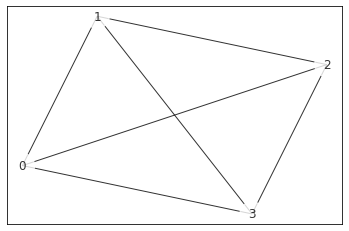

In [227]:
#Hard to color: Prism
#G = nx.Graph([(0,1),(1,2),(2,3),(0,3),(0,4),(3,4),(2,5),(1,5),(4,5)])

#nice testing graph k = 2
#G = nx.Graph([(0,1),(1,2),(1,3),(0,2),(2,4),(1,4)])

#nice testing graph k > 2
G = nx.Graph([(0,1),(1,2),(2,0),(3,2),(1,3),(3,0)])

#G = nx.Graph([(0,1)])
k_col = k_color(G)
k_col.draw()
# k_col.build_circuit(2,[1],[2])
# k_col.circuit.circ.draw()


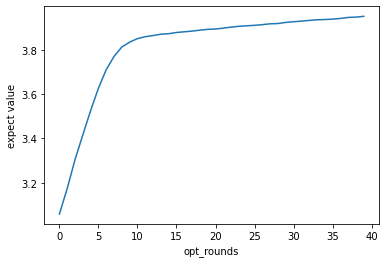

Wall time: 4min 22s


In [228]:
%%time

colors = 2
rounds = 40
depth = 3
shots = 100000
rate = 0.01



curve = k_col.train(colors, rounds, depth, shots, rate)
plt.plot(curve)
plt.ylabel('expect value')
plt.xlabel('opt_rounds')
plt.show()

In [220]:
# %%time


# curve = k_col.train(colors, rounds, depth, shots, rate)
# plt.plot(curve)
# plt.ylabel('expect value')
# plt.xlabel('opt_rounds')
# plt.show()

optimal as bitstring: 100101100
node  0  has colour  10
node  1  has colour  01
node  2  has colour  01
node  3  has colour  10
total possible answers 16
trained beta: [0.49137  0.746805 0.518335]
trained gamma: [0.69547  0.6994   0.498585]
[0 1 1 0]
Optimal amount of properly colored edges: 4


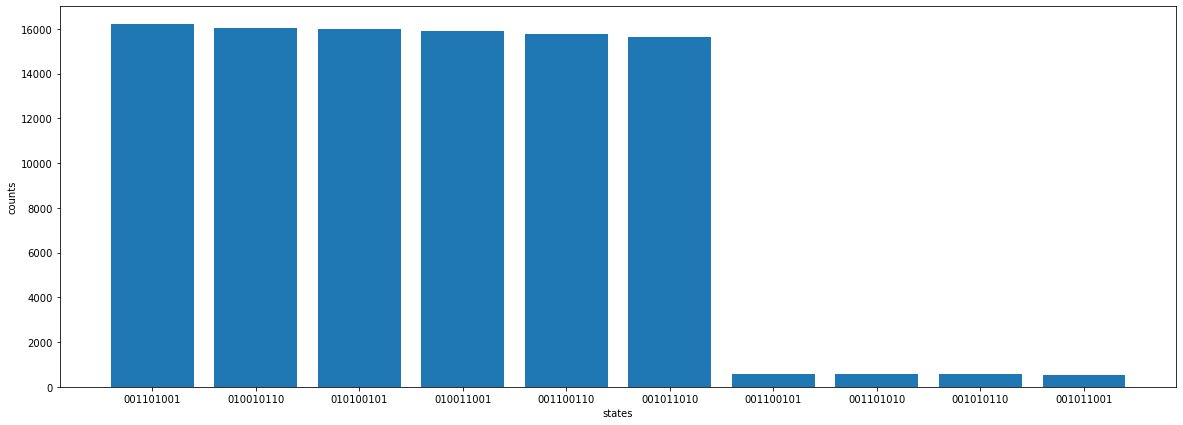

In [229]:
#plot_histogram(k_col.counts, title="Bell initial statevector")

counts = k_col.counts
k=colors
n=len(G)

#print(counts)
newcounts = sorted(counts.items(), key = lambda x:(x[1], x[0]), reverse=True)
optimum = newcounts[0][0]
optimum = optimum[::-1]
print("optimal as bitstring:", optimum)
# print(newcounts)
# print(np.array(newcounts)[:,1].astype(int))
for i in range(n):
    print("node ", i, " has colour ", optimum[i*k:i*k+k])


bars = 10

print("total possible answers", len(counts))

print('trained beta:', k_col.beta)
print('trained gamma:', k_col.gamma)


color = np.argmax(np.array(list(optimum)[0:len(optimum[::-1])-1], dtype= np.int).reshape(n, -1), axis = 1)
print(color)
#color = color[::-1]
#print(color)
value = 0
for i,j in G.edges:
    if color[i] != color [j]:
        value += 1
print("Optimal amount of properly colored edges:", value)


plt.figure(figsize=(20,7))
plt.bar(range(min(len(counts),bars)), list(np.array(newcounts)[0:bars,1].astype(int)), align='center')
plt.xticks(range(min(len(counts),bars)), list(np.array(newcounts)[0:bars,0]))
plt.xlabel('states')
plt.ylabel('counts')
plt.show()

In [230]:
value = np.zeros(len(counts))
newcounts = sorted(counts.items(), key = lambda x:(x[1], x[0]), reverse=True)


for l in range(len(newcounts)):
    optimum = newcounts[l][0]
    optimum = optimum[::-1]
    color = np.argmax(np.array(list(optimum)[0:len(optimum[::-1])-1], dtype= np.int).reshape(n, -1), axis = 1)
    #color = np.argmax(np.array(list(optimum)[1:], dtype= np.int).reshape(n, -1), axis = 1)
    #print(color)
    for i,j in G.edges:
        if color[i] != color [j]:
            value[l] += 1
print(value)

[4. 4. 4. 4. 4. 4. 3. 3. 3. 3. 3. 3. 3. 3. 0. 0.]


In [123]:
%%time
k_col.heatmap(k = 2, p = 1, n_gamma = 40, n_beta = 20)

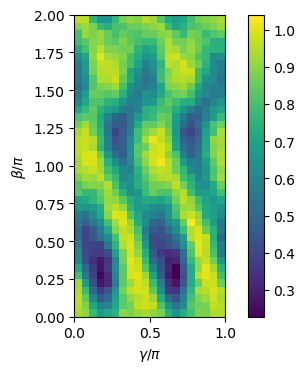

Wall time: 2min 38s


In [399]:
%%time
k_col.heatmap(k = 2, p = 2, n_gamma = 40, n_beta = 20)

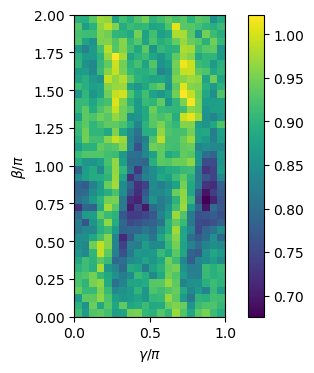

Wall time: 3min


In [400]:
%%time
k_col.heatmap(k = 2, p = 3, n_gamma = 40, n_beta = 20)

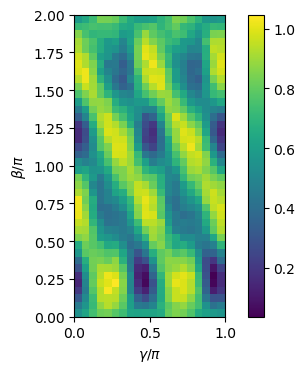

Wall time: 2min 52s


In [401]:
%%time
k_col.heatmap(k = 2, p = 0, n_gamma = 40, n_beta = 20)

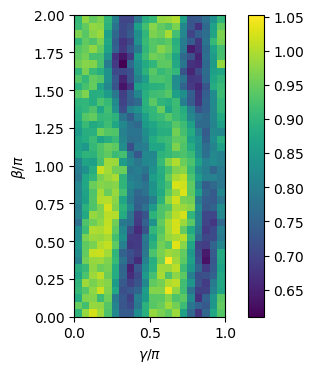

Wall time: 3min 58s


In [402]:
%%time
k_col.heatmap(k = 2, p = 4, n_gamma = 40, n_beta = 20)

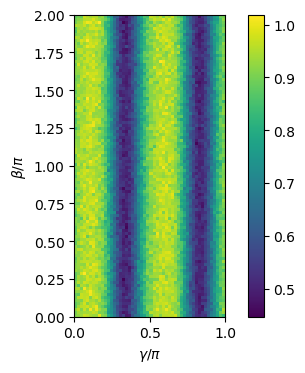

Wall time: 16min 7s


In [403]:
%%time
k_col.heatmap(k = 2, p = 5, n_gamma = 100, n_beta = 50)